# Run under strax

In [ ]:
import straxen, strax, wfsim
print(strax.__file__, 'v', strax.__version__)
print(straxen.__file__, 'v', straxen.__version__)
print(wfsim.__file__, 'v', wfsim.__version__)

In [2]:
pwd

'/home/zhut/WFSim_Tests/S1Bias'

In [3]:
import os, sys
import numba
import numpy as np
import pandas as pd
from multihist import Histdd, Hist1d
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import zlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

In [4]:
run_number = np.arange(20, 40)
len(run_number)

20

In [5]:
strax.Mailbox.DEFAULT_TIMEOUT=10000
instruction_dtype = wfsim.instruction_dtype
from scipy.stats import truncnorm

def rand_instructions(c, df=None):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    # Put 10 S1s in each event
    instructions = np.zeros(10 * n, dtype=instruction_dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['time'] = np.repeat(uniform_times, 10) * int(1e9)
    instructions['time'] += np.tile(np.linspace(0, 500e6, 11).astype(int)[:10], n)
    instructions['event_number'] = np.digitize(instructions['time'],
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile([1] * 10, n)
    instructions['recoil'] = ['er' for i in range(n * 10)]

    r = np.sqrt(np.random.uniform(0, 40**2, n * 10))
    t = np.random.uniform(-np.pi, np.pi, n * 10)

    instructions['x'] = r * np.sin(t)
    instructions['y'] = r * np.cos(t)
    instructions['z'] = np.random.uniform(-95, -5, n * 10)

    # There's a x10 difference between input nphotons and outout nphotons
    nphotons = np.random.choice(np.arange(10, 500), replace=True, size=n * 10)

    instructions['amp'] = nphotons
    return instructions

for rn in run_number[:]:
    c = dict(nchunk=2000, event_rate=1, chunk_size=1)
    inst = rand_instructions(c)
    pd.DataFrame(inst).to_csv('./instructions/test_rnd_%d.csv'%rn, index=False)

In [7]:
import zlib
dtype = [
('event_number', 'i8'),
('event_start', 'i8'),
('run_number', 'i8'),
('s1', 'f8'),
('s1_area_fraction_top', 'f8'),
('s1_range_50p_area', 'f8'),
('s1_rise_time', 'f8'),
('s1_center_time', 'f8'),
('s1_n_hits', 'f8'),
('s1_tight_coincidence', 'i4'),
('time', 'i8'),
('endtime', 'i8'),
]

name = str(rn)
with open('/dali/lgrandi/zhut/minitrees/pax_s1b_tb/%s_HitPerPE'%name, 'rb') as f:
    data = zlib.decompress(f.read())
    data = np.frombuffer(data, dtype=dtype)
    
truth = pd.read_csv('/dali/lgrandi/zhut/sim/pax_data/XENON1T_MC_%s/XENON1T-%s-truth.csv'%(name, name))
truth.drop(columns=['recoil'], inplace=True)
truth = truth.to_records()
truth['time'] = truth['t_first_photon']

In [8]:
ix = strax.fully_contained_in(truth, data)
m = np.where(ix>0)[0]
new_truth = truth[m]
new_data = data[ix[m]]

In [9]:
new_data = strax.merge_arrs([new_data, new_truth])

In [10]:
import os, sys
import numba
import numpy as np
import pandas as pd
from multihist import Histdd, Hist1d
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import zlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

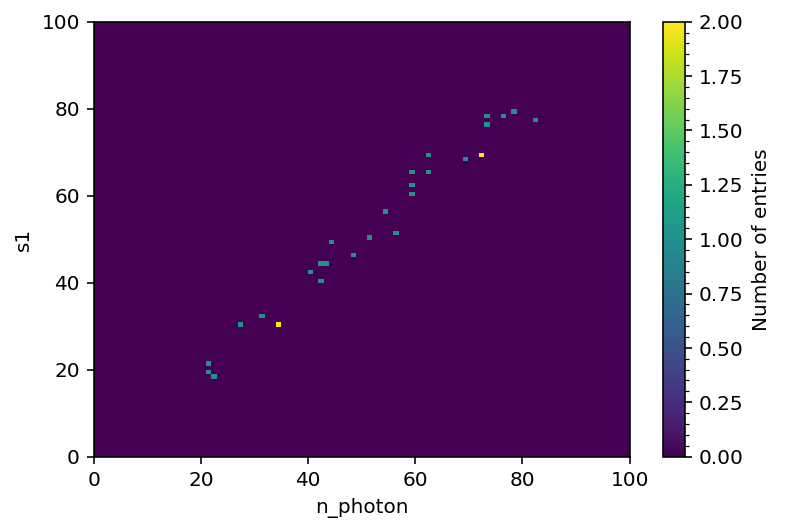

In [13]:
mh = Histdd(dimensions=[('n_photon', np.linspace(0, 100, 101)),
                        ('s1', np.linspace(0, 100, 101))])
            
mh.add(new_data)
mh.plot()
plt.show()